In [1]:
!pip install PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 936.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 8.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns
from sklearn.linear_model import LinearRegression
from collections import defaultdict

# Arbitrage Pricing Theory(APT)
- This section aims to create a covariance matrix based on a regression model, to incorporate the underlying relationship between macroeconomic factors and assets

In [3]:
tickers = "COFF.L GS C ALAB ICLN FCFS GBPG.L XGBE.MI RDY HDB CTEC.AS"
df_assets = yf.download(tickers=tickers, start="2014-01-01", end="2025-01-01", interval="1d")
close_df = df_assets["Close"]

[*********************100%***********************]  11 of 11 completed


In [4]:
# Because ALAB is a recently new listing at 2024, we have to develop a way to incorporate the pricing data
# here we did a simple linear extrapolation, while simple it ensures the data is included
first_valid_idx = close_df['ALAB'].first_valid_index()
if first_valid_idx is not None and first_valid_idx > close_df.index[0]:

  first_value = close_df.loc[first_valid_idx, 'ALAB']
  total_days = (first_valid_idx - close_df.index[0]).days

  dates_to_extrapolate = close_df.loc[close_df.index < first_valid_idx].index

  extrapolated_values = [((date - close_df.index[0]).days / total_days) * first_value
                               for date in dates_to_extrapolate]

  close_df.loc[dates_to_extrapolate, 'ALAB'] = extrapolated_values

In [5]:
df_assets_quarterly = close_df.resample("QE").last()
asset_returns_df = df_assets_quarterly.pct_change().dropna()

In [6]:
# Data must be in google drive specific location
from google.colab import drive
drive.mount("/content/drive")

date1 = "2014-01-01"
date2 = "2025-01-01"
factors = {
    "CPIUS": "/content/drive/My Drive/EconDB/CPIUS.csv",
    "CPIUK": "/content/drive/My Drive/EconDB/CPIUK.csv",
    "RGDPIN": "/content/drive/My Drive/EconDB/RGDPIN.csv",
    "IPCN": "/content/drive/My Drive/EconDB/IPCN.csv",
    "RETACN": "/content/drive/My Drive/EconDB/RETACN.csv",

}

Mounted at /content/drive


In [7]:
# Due to the way econdb aggregates dates we have to use a brute method to manually label quarters as pandas simply would not work
def manual_resample_to_quarterly(df):
    """Manual quarter labeling + average per quarter."""
    quarterly_data = []
    for _, row in df.iterrows():
        y, m = row["Date"].year, row["Date"].month
        if m in [1, 2, 3]:
            q = f"{y}-Q1"
        elif m in [4, 5, 6]:
            q = f"{y}-Q2"
        elif m in [7, 8, 9]:
            q = f"{y}-Q3"
        else:
            q = f"{y}-Q4"
        quarterly_data.append((q, row[1]))

    # Aggregate by quarter
    temp = defaultdict(list)
    for q, val in quarterly_data:
        temp[q].append(val)
    result = {q: np.mean(vals) for q, vals in temp.items()}
    return result

# Read, rename columns, and store quarterly factor data
data_resampled = {}
for name, filepath in factors.items():
    df_f = pd.read_csv(filepath)
    df_f.columns = ["Date", name]
    df_f["Date"] = pd.to_datetime(df_f["Date"])
    data_resampled[name] = manual_resample_to_quarterly(df_f)

# Combine factor data into final DataFrame
combined_data = defaultdict(dict)
for factor_name, qdict in data_resampled.items():
    for quarter, val in qdict.items():
        combined_data[quarter][factor_name] = val

final_df = pd.DataFrame.from_dict(combined_data, orient="index").sort_index()
final_df.index = pd.PeriodIndex(final_df.index, freq="Q")
final_df = final_df[(final_df.index >= date1) & (final_df.index <= date2)]
factors_returns_df = final_df.pct_change().dropna()

<ipython-input-7-1c3a447a475d>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quarterly_data.append((q, row[1]))
<ipython-input-7-1c3a447a475d>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quarterly_data.append((q, row[1]))
<ipython-input-7-1c3a447a475d>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quarterly_data.append((q, row[1]))
<ipython-input-7-1c3a447a475d>:15: FutureWarning: Series.__getitem__ treating keys as po

In [8]:
#3) Align Asset & Factor Returns

factors_returns_df.index = factors_returns_df.index.to_timestamp("Q", "end")
asset_returns_df.index = asset_returns_df.index.to_period("Q").to_timestamp("Q", "end")
common_index = factors_returns_df.index.intersection(asset_returns_df.index)

aligned_asset_returns = asset_returns_df.loc[common_index]
aligned_factors_returns = factors_returns_df.loc[common_index]

aligned_asset_matrix = aligned_asset_returns.values
aligned_factors_matrix = aligned_factors_returns.values

In [9]:
# 4) APT: Factor Regression

n_assets = len(tickers.split())
n_factors = len(factors)

alphas, betas, residuals = [], [], []

for i in range(n_assets):
    lr = LinearRegression()
    lr.fit(aligned_factors_matrix, aligned_asset_matrix[:, i])
    alphas.append(lr.intercept_)
    betas.append(lr.coef_)
    predicted = lr.predict(aligned_factors_matrix)
    residuals.append(aligned_asset_matrix[:, i] - predicted)

idiosyncratic_variances = [np.var(r) for r in residuals]
B = np.array(betas)
Sigma_epsilon = np.diag(idiosyncratic_variances)
Sigma_F = np.cov(aligned_factors_matrix, rowvar=False)

covariance_matrix = B @ Sigma_F @ B.T + Sigma_epsilon
expected_factor_returns = np.mean(aligned_factors_matrix, axis=0)
expected_asset_returns_apt = np.array(alphas) + B @ expected_factor_returns

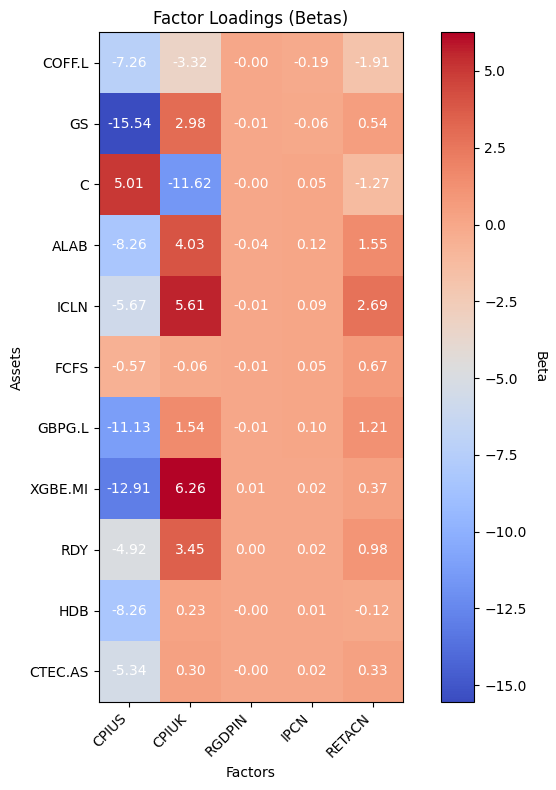

In [10]:
# Visualizing factor loadings
betas_df = pd.DataFrame(B, index=tickers.split(), columns=list(factors.keys()))

fig, ax = plt.subplots(figsize=(8, 8))

im = ax.imshow(B, cmap='coolwarm', interpolation='nearest')

ax.set_xticks(np.arange(len(factors)))
ax.set_yticks(np.arange(len(tickers.split())))
ax.set_xticklabels(list(factors.keys()), rotation=45, ha='right')
ax.set_yticklabels(tickers.split())

# Add annotations (beta values)
for i in range(len(tickers.split())):
    for j in range(len(factors)):
        text = ax.text(j, i, f"{B[i, j]:.2f}", ha="center", va="center", color="w")

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Beta", rotation=-90, va="bottom")

ax.set_title('Factor Loadings (Betas)')
ax.set_xlabel('Factors')
ax.set_ylabel('Assets')

plt.tight_layout()
plt.show()

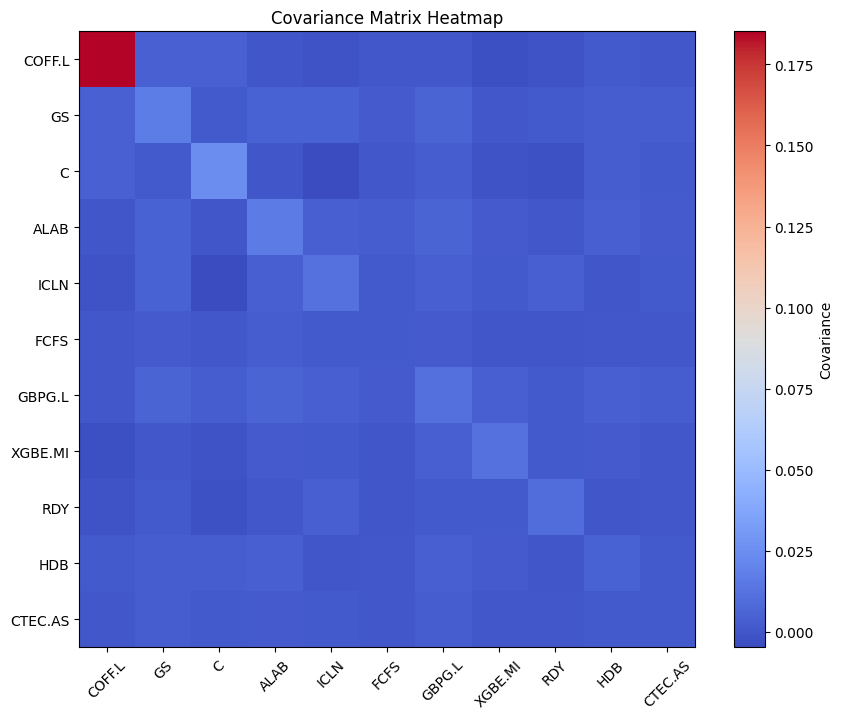

In [11]:
# Visualizing Covariance Matrix
plt.figure(figsize=(10, 8))
plt.title("Covariance Matrix Heatmap")
plt.imshow(covariance_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Covariance")
plt.xticks(range(len(tickers.split())), tickers.split(), rotation=45)
plt.yticks(range(len(tickers.split())), tickers.split())
plt.show()

# 2. Black-Litterman Optimization
- This section takes the covariance matrix generated from APT, combined with investor subjective views through bayesian methods to obtain posterior returns and covariance matrix
- Finally efficient frontier is used to optimize through maximizing sharpe ratio

In [12]:
# 1, Black Litterman Inputs to Prior
assets_list = tickers.split()
cov_matrix = pd.DataFrame(covariance_matrix, index=assets_list, columns=assets_list)
# Hardcoded market caps, as yfinance does not offer direct route for certain assets
# For bonds, the 'market cap' is approximated by multiplying the price of bonds with nominal outstanding notes
market_caps = {
    "COFF.L": 116_000_000_000,
    "GS":   196_489_000_000,
    "C":    150_149_000_000,
    "ALAB": 21_140_000_000,
    "ICLN": 802_140_000,
    "FCFS":    5_020_000_000,
    "GBPG.L":    4_212_152_612,
    "XGBE.MI": 93_100_000,
    "RDY": 12_600_000_000,
    "HDB": 148_000_000_000,
    "CTEC.AS":  1_330_000_000,
}

# Market-implied risk aversion parameter (delta)
spy_data = yf.download("SPY", start="2014-01-01", end="2025-01-01")["Close"]
risk_free_rate = 0.04628 #US 10 Year Treasury Yield as of 19/01/2025
delta = black_litterman.market_implied_risk_aversion(spy_data, risk_free_rate=risk_free_rate)

# Market-implied prior returns
market_prior = black_litterman.market_implied_prior_returns(market_caps, delta, cov_matrix)

[*********************100%***********************]  1 of 1 completed


In [16]:
# 2, Incorporating views
# Absolute Views
absolute_views = {
    "COFF.L": 0.13,
    "GS":   0.15,
    "C":    0.15,
    "ALAB": 0.13,
    "ICLN": 0.22,
    "FCFS": 0.06,
    "GBPG.L": 0.09,
    "XGBE.MI": 0.7,
    "RDY": 0.125,
    "HDB":  0.230,
    "CTEC.AS":  0.2,
}

bl = BlackLittermanModel(
    cov_matrix=cov_matrix,
    pi=market_prior,
    absolute_views=absolute_views
)
#Posterior returns and covariance matrix
posterior_returns = bl.bl_returns()
posterior_cov = bl.bl_cov()

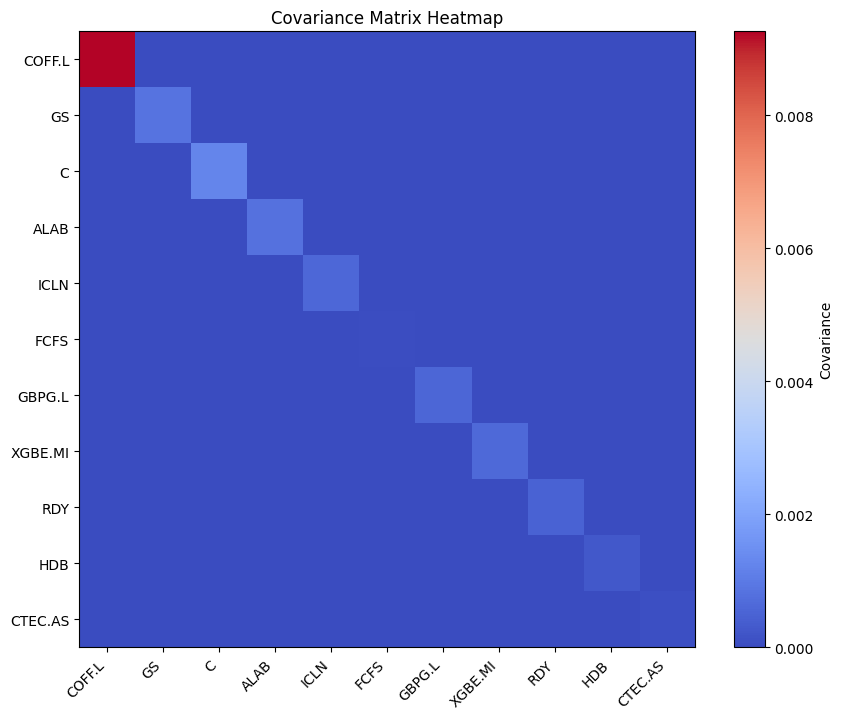

In [14]:
#Visualize covariance matrix
plt.figure(figsize=(10, 8))
plt.title("Covariance Matrix Heatmap")
plt.imshow(bl.omega, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Covariance")  # Add colorbar with label
plt.xticks(range(len(bl.tickers)), bl.tickers, rotation=45, ha='right')  # Rotate x-axis labels
plt.yticks(range(len(bl.tickers)), bl.tickers)
plt.show()


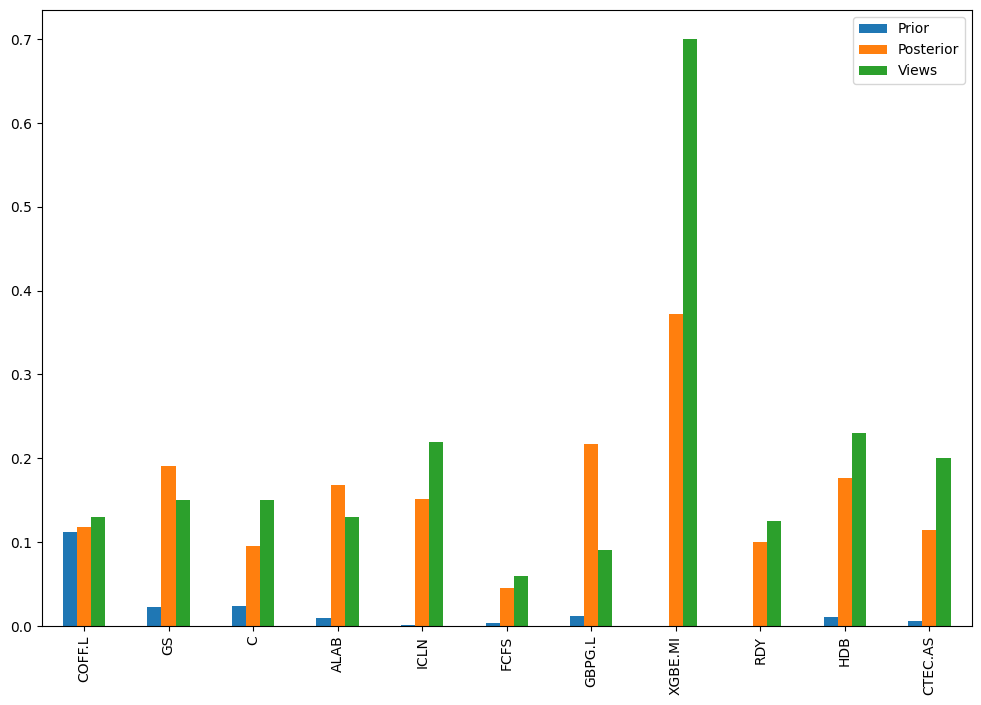

In [15]:
#visualize and compare how posterior is affected by priors and views
rets_df = pd.DataFrame([market_prior, posterior_returns, pd.Series(absolute_views)],
             index=["Prior", "Posterior", "Views"]).T
rets_df.plot.bar(figsize=(12,8));

In [18]:
# 3, Compute posterior with efficient frontier
# Set weight constraints: weights between min of 2% and max of 15% per asset
weight_bounds = (0.02, 0.15)


min_return = min(posterior_returns)

ef_temp = EfficientFrontier(posterior_returns, posterior_cov, weight_bounds=weight_bounds)
max_return = ef_temp._max_return()
target_returns = np.linspace(min_return, max_return, 100)

ef_risks = []
ef_returns = []
for target_return in target_returns:
    ef_temp = EfficientFrontier(posterior_returns, posterior_cov, weight_bounds=weight_bounds)
    try:
        ef_temp.efficient_return(target_return)
        ret, vol, _ = ef_temp.portfolio_performance(verbose=False)
        ef_returns.append(ret)
        ef_risks.append(vol)
    except Exception as e:
        continue

# Generate Random Portfolios
num_portfolios = 5000
rand_returns = []
rand_risks = []
rand_sharpes = []

for _ in range(num_portfolios):
    # Generate random weights that sum to 1 and respect bounds.
    weights = np.random.random(len(posterior_returns))
    weights = weights / np.sum(weights)
    # Enforce the weight bounds: if any weight exceeds 0.15, re-sample (using simple rejection sampling)
    while any(weights > weight_bounds[1]):
        weights = np.random.random(len(posterior_returns))
        weights = weights / np.sum(weights)
    port_return = np.dot(weights, posterior_returns)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(posterior_cov, weights)))
    sharpe_ratio = (port_return - risk_free_rate) / port_vol
    rand_returns.append(port_return)
    rand_risks.append(port_vol)
    rand_sharpes.append(sharpe_ratio)

# Calculate the maximum Sharpe ratio portfolio and its performance
ef = EfficientFrontier(posterior_returns, posterior_cov, weight_bounds=weight_bounds)
max_sharpe_weights = ef.max_sharpe()
max_sharpe_performance = ef.portfolio_performance(verbose=True)  # returns (return, volatility, sharpe)
ms_ret, ms_vol, ms_sharpe = max_sharpe_performance



Expected annual return: 15.9%
Annual volatility: 4.5%
Sharpe Ratio: 3.54


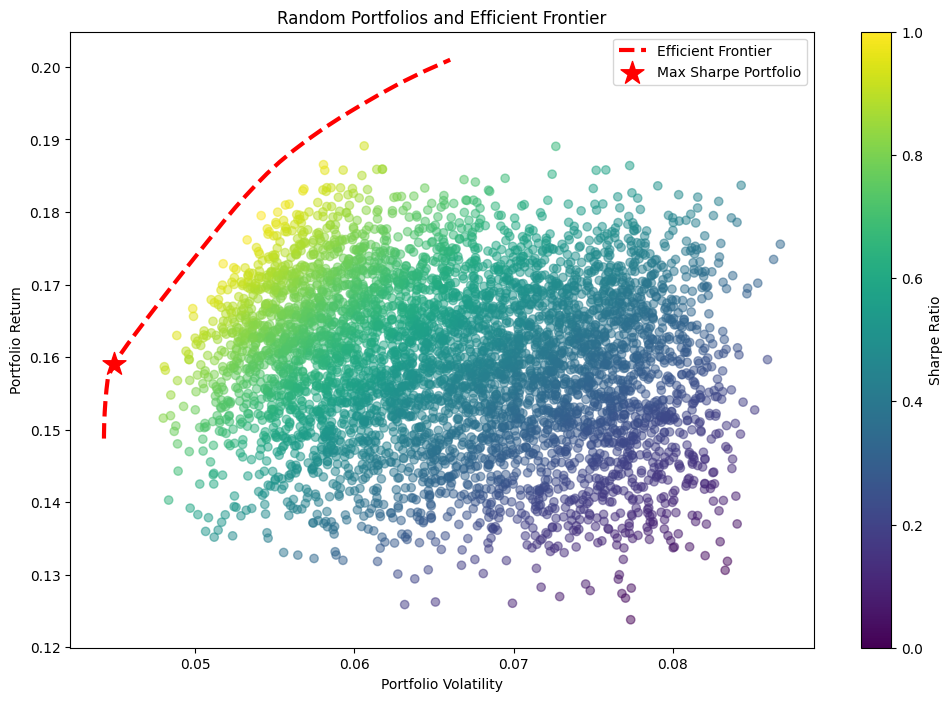

Max Sharpe Portfolio Weights:
COFF.L     0.02000
GS         0.02000
C          0.07484
ALAB       0.02000
ICLN       0.12660
FCFS       0.15000
GBPG.L     0.02323
XGBE.MI    0.15000
RDY        0.11533
HDB        0.15000
CTEC.AS    0.15000
dtype: float64


In [19]:
# Plot Random Portfolios and the Efficient Frontier, and mark the Max Sharpe portfolio.
plt.figure(figsize=(12, 8))
plt.scatter(rand_risks, rand_returns, c=rand_sharpes, cmap='viridis', alpha=0.5)
plt.plot(ef_risks, ef_returns, 'r--', linewidth=3, label="Efficient Frontier")
# Mark the max Sharpe portfolio with a star marker.
plt.scatter(ms_vol, ms_ret, marker="*", s=300, c='red', label="Max Sharpe Portfolio")
plt.colorbar(label="Sharpe Ratio")
plt.title("Random Portfolios and Efficient Frontier")
plt.xlabel("Portfolio Volatility")
plt.ylabel("Portfolio Return")
plt.legend()
plt.show()

# Display the maximum Sharpe portfolio weights
cleaned_weights = ef.clean_weights()
print("Max Sharpe Portfolio Weights:")
print(pd.Series(cleaned_weights))

# Comparison of Models
- We compare our model above with the traditional methodology of optimizing based off historical prices

In [20]:
#Here we only retrieve the adjusted close price, and then resample to get the adjusted close price for the last day of each year
# adjusted close price adjusted for corporate actions like stock splits, and dilutive effects

df_assets_2 = df_assets_quarterly.resample('YE').last() #.resample will adjust the frequency of our time-series data, and in this case retrieve only the last close value of each stock, each year

annual_returns = df_assets_quarterly.apply(lambda x: x.pct_change()).dropna() #Calculate the annual percentage change of each stock (from the last day of each year) and put this in a new df

ann_returns = annual_returns.mean()
ann_cov = annual_returns.cov()

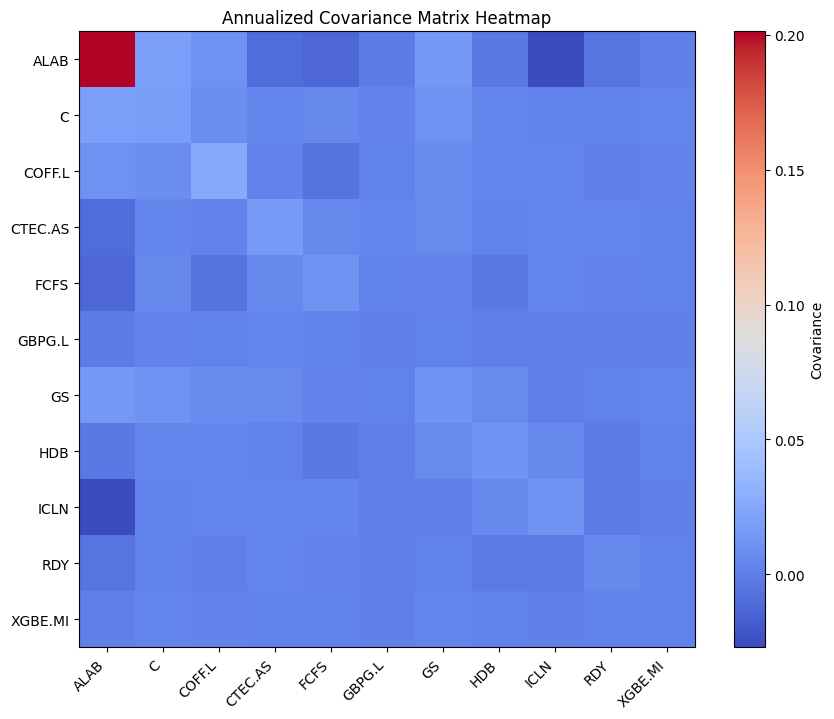

In [21]:
# visualize cov matrix
plt.figure(figsize=(10, 8))
plt.title("Annualized Covariance Matrix Heatmap")
plt.imshow(ann_cov, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Covariance")
plt.xticks(range(len(ann_cov.columns)), ann_cov.columns, rotation=45, ha='right')
plt.yticks(range(len(ann_cov.columns)), ann_cov.columns)
plt.show()

In [22]:
# Calculate the maximum Sharpe ratio portfolio and its performance
ef_2 = EfficientFrontier(ann_returns, ann_cov, weight_bounds=weight_bounds)
max_sharpe_weights = ef_2.max_sharpe()
max_sharpe_performance = ef_2.portfolio_performance(verbose=True)  # returns (return, volatility, sharpe)
ms_ret2, ms_vol2, ms_sharpe2 = max_sharpe_performance


# Display the maximum Sharpe portfolio weights
cleaned_weights = ef.clean_weights()
print("Max Sharpe Portfolio Weights:")
print(pd.Series(cleaned_weights))

Expected annual return: 3.7%
Annual volatility: 6.5%
Sharpe Ratio: 0.57
Max Sharpe Portfolio Weights:
COFF.L     0.02000
GS         0.02000
C          0.07484
ALAB       0.02000
ICLN       0.12660
FCFS       0.15000
GBPG.L     0.02323
XGBE.MI    0.15000
RDY        0.11533
HDB        0.15000
CTEC.AS    0.15000
dtype: float64


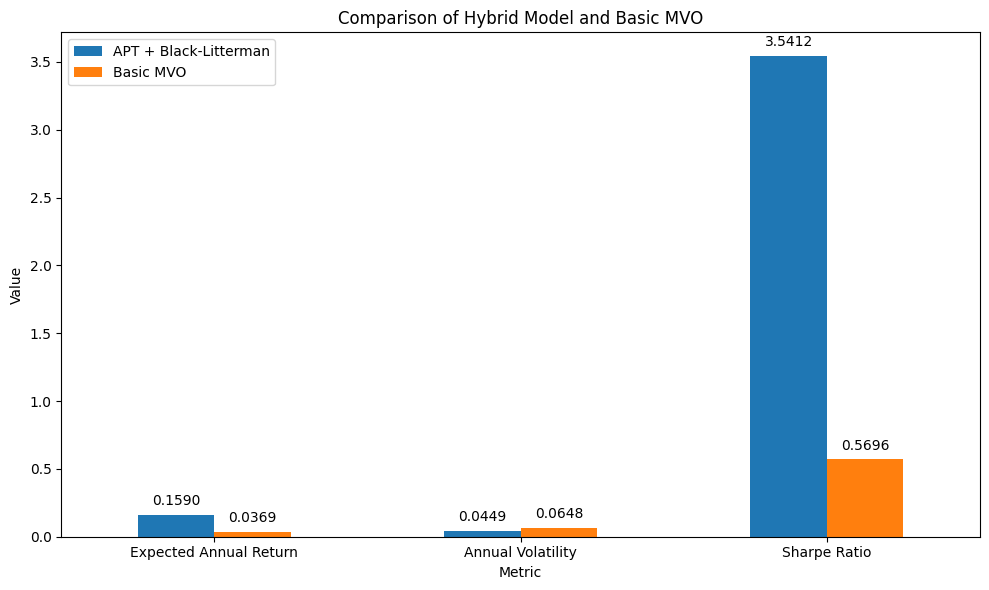

In [23]:
#visualization of comparison between our model and basic MVO model based off historical prices
data = {
    'Metric': ['Expected Annual Return', 'Annual Volatility', 'Sharpe Ratio'],
    'APT + Black-Litterman': [ms_ret, ms_vol, ms_sharpe],
    'Basic MVO': [ms_ret2, ms_vol2, ms_sharpe2]
}

df = pd.DataFrame(data)

df.set_index('Metric', inplace=True)
ax = df.plot(kind='bar', figsize=(10, 6))

ax.set_ylabel("Value")
ax.set_title("Comparison of Hybrid Model and Basic MVO")

# Add data labels on top of the bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xticks(rotation=0) # Keep x-axis labels horizontal
plt.tight_layout()
plt.show()